# Dataloader overview

In [36]:
%run __common.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:329: UserWarning: Distributed manager is already intialized
  warn("Distributed manager is already intialized")


## High level perspective, from the main training script

Reviewing https://vscode.dev/github/schuups/DSM500/blob/Baseline/modulus-a5275d8/examples/weather/graphcast/train_graphcast.py, the parts that pertain to the dataloader are:

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
from modulus.datapipes.climate import ERA5HDF5Datapipe

def main(cfg: DictConfig) -> None:
    ...
    DataPipe = ERA5HDF5Datapipe
    ...
    trainer = GraphCastTrainer(cfg, dist, rank_zero_logger)
    ...
    while True:
        for _, data in enumerate(trainer.datapipe):
            ...
            if iter >= cfg.num_iters_step1 + cfg.num_iters_step2 and not finetune:
                finetune = True
                ...
            ...
            if (finetune and (iter - (cfg.num_iters_step1 + cfg.num_iters_step2)) % cfg.step_change_freq== 0 and iter != tagged_iter):
                update_dataloader = True
                tagged_iter = iter
            if update_dataloader:
                num_rollout_steps = (iter - (cfg.num_iters_step1 + cfg.num_iters_step2)) // cfg.step_change_freq + 2
                trainer.datapipe = DataPipe(
                    ...
                    num_steps=num_rollout_steps,
                    ...
                )
                update_dataloader = False
                rank_zero_logger.info(f"Switching to {num_rollout_steps}-step rollout!")
                break

            # Prepare the input & output
            invar = data[0]["invar"]
            outvar = data[0]["outvar"]
            try:
                cos_zenith = data[0]["cos_zenith"]
            except KeyError:
                cos_zenith = None
            try:
                time_idx = data[0]["time_of_year_idx"].item()
            except KeyError:
                time_idx = None

            invar_cat = prepare_input(
                invar,
                cos_zenith,
                num_history=cfg.num_history,
                static_data=trainer.static_data,
                step=1,
                time_idx=time_idx,
                stride=cfg.stride,
                dt=cfg.dt,
                num_samples_per_year=cfg.num_samples_per_year_train,
                device=dist.device,
            )
            invar_cat = invar_cat.to(dtype=trainer.dtype)
            outvar = outvar.to(dtype=trainer.dtype)

            # training step
            loss = trainer.train(invar_cat, outvar)
            ...
if __name__ == "__main__":
    main()
```
</div>

Lots of references to a `trainer` object, which is defined in the same file. This is what of it is relevant for the dataloader:

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class GraphCastTrainer(BaseTrainer):
    def __init__(self, cfg: DictConfig, dist, rank_zero_logger):
        ...
        DataPipe = (SyntheticWeatherDataLoader if cfg.synthetic_dataset else ERA5HDF5Datapipe)
        ...
        self.datapipe = DataPipe(
            ...
            num_steps=1,
            ...
        )
        if self.static_dataset_path:
            self.static_data = StaticData(self.static_dataset_path, self.latitudes, self.longitudes).get()
            ...
```
</div>


##### Comments

- `trainer.datapipe` is the iterator generating the data fed to the model. It starts with `num_steps` set to 1, and later in the training this value is increased by replacing the dataloader.
- Such data is augmented with static data and other elements that change at every iteration.
- The data generation starts in the `ERA5HDF5Datapipe` class.


## What data is generated by `ERA5HDF5Datapipe`?

Starting from the initial datapipe (i.e. `num_steps=1`)

In [37]:
from train_graphcast import GraphCastTrainer

trainer = GraphCastTrainer(cfg, dist, rank_zero_logger)

Provided checkpoint directory /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/checkpoints does not exist, skipping load


Loaded validation datapipe of size 6


Iteration: 0
List length: 1
----------
Data keys: dict_keys(['outvar', 'invar', 'time_of_year_idx', 'cos_zenith'])
	 outvar torch.Size([1, 1, 21, 721, 1440])
	 invar torch.Size([1, 21, 721, 1440])
	 time_of_year_idx torch.Size([1, 1])
	 cos_zenith torch.Size([1, 2, 1, 721, 1440])
----------
time_of_year_idx=tensor([[1165]])
Show invar


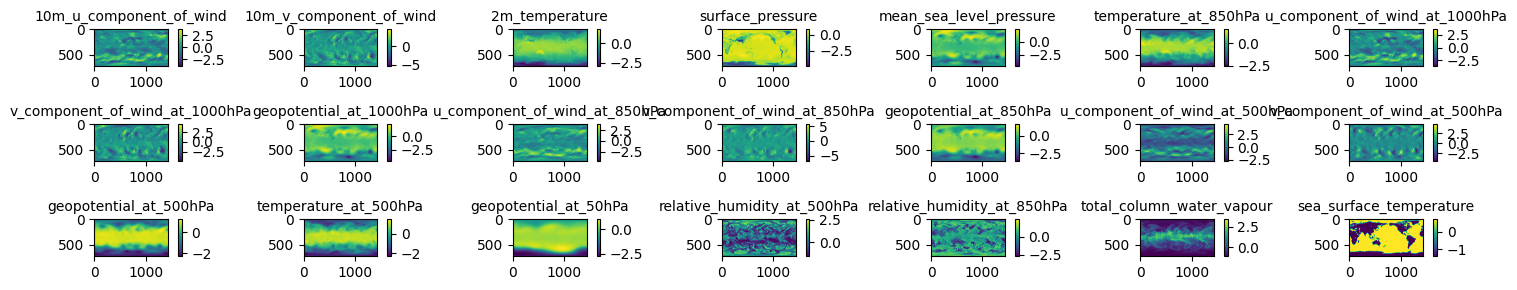

Show outvar


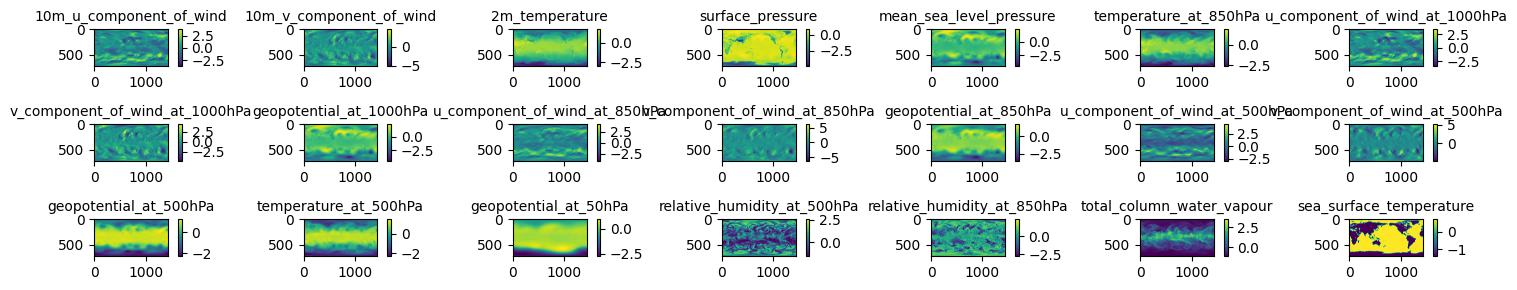

Show cos_zenith


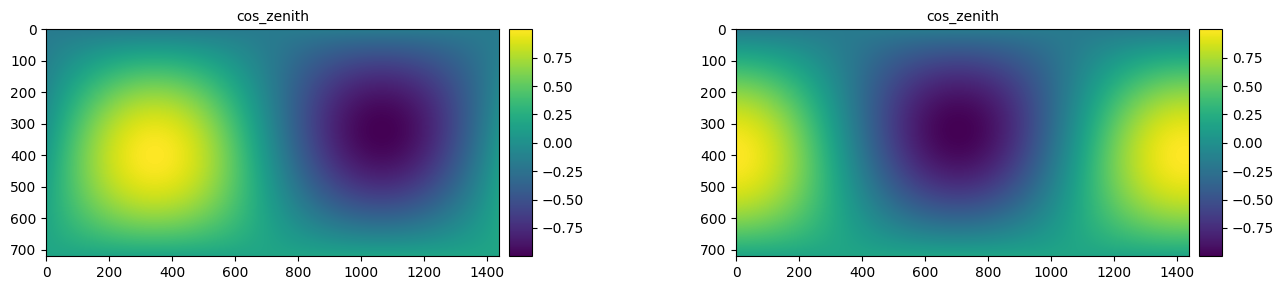

In [38]:
metadata = get_dataset_metadata()

for i, data in enumerate(trainer.datapipe):
    print("=" * 50)
    print("Iteration:", i)
    print("List length:", len(data))
    data = data[0]
    print("-" * 10)

    print("Data keys:", data.keys())
    for key, value in data.items():
        print("\t", key, value.shape)
    print("-" * 10)
    
    invar = data["invar"].to("cpu")
    outvar = data["outvar"].to("cpu")
    cos_zenith = data["cos_zenith"].to("cpu")
    time_of_year_idx = data["time_of_year_idx"]
    print(f"{time_of_year_idx=}")

    print("Show invar")
    fig, axs = plt.subplots(3, 7, figsize=(15, 3))
    for data, ax, label in zip(invar[0], axs.flatten(), metadata["coords"]["channel_labels"]):
        plot(data, label, ax)
    plt.show()

    print("Show outvar")
    fig, axs = plt.subplots(3, 7, figsize=(15, 3))
    for data, ax, label in zip(outvar[0, 0], axs.flatten(), metadata["coords"]["channel_labels"]):
        plot(data, label, ax)
    plt.show()

    print("Show cos_zenith")
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    for data, ax in zip(cos_zenith[0], axs.flatten()):
        plot(data[0], "cos_zenith", ax)

    break

##### Comments
- As expected, the datapipe produces data from the files, at t0 and t0+1
- It adds `cos_zenith` which is an approximation of the solar radiation of Earth at a given time. It is generated for all timesteps of interest (inputs and outputs).
- It returns the `time_of_year_idx` which is an index for the year file selected.
- In some cases, the `10m_u_component_of_wind` channel (index 0) shows pitch black. Is it normal?

### Check 10m_u_component_of_wind for a case where it shows pitch black

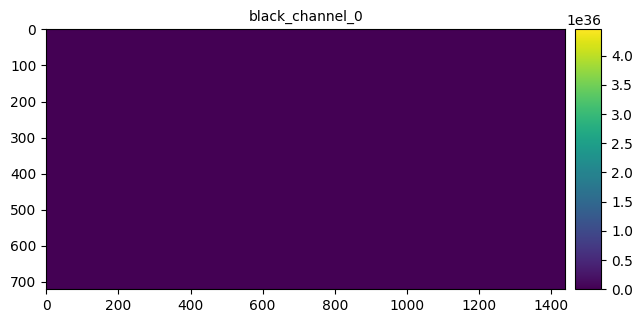

In [ ]:
black_channel_0 = invar[0, 0]

plot(black_channel_0, "black_channel_0")

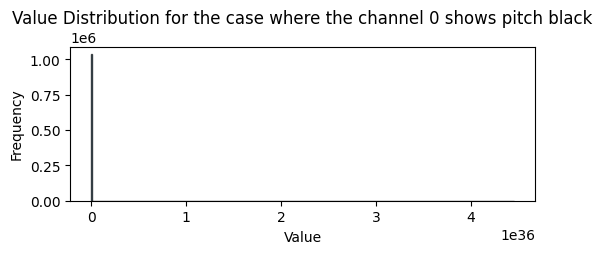

In [18]:
plt.figure(figsize=(6, 2))
plt.hist(black_channel_0.flatten(), bins=1000, edgecolor='k', alpha=0.7)
plt.title("Value Distribution for the case where the channel 0 shows pitch black")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

How many values are so abnormal?

In [21]:
max_value = black_channel_0.max()

(black_channel_0 == max_value).sum(), (black_channel_0 != max_value).sum()

(tensor(1), tensor(1038239))

#### Comment
- There is just one value with an abormally high value. Assuming it is a mistake, maybe it should be removed/replaced with e.g. the mean value for the field.

## What changes when the `datapipe` is updated?

num_rollout_steps=7
Iteration: 0
List length: 1
----------
Data keys: dict_keys(['outvar', 'invar', 'time_of_year_idx', 'cos_zenith'])
	 outvar torch.Size([1, 7, 21, 721, 1440])
	 invar torch.Size([1, 21, 721, 1440])
	 time_of_year_idx torch.Size([1, 1])
	 cos_zenith torch.Size([1, 8, 1, 721, 1440])
----------
time_of_year_idx=tensor([[1165]])
Show invar


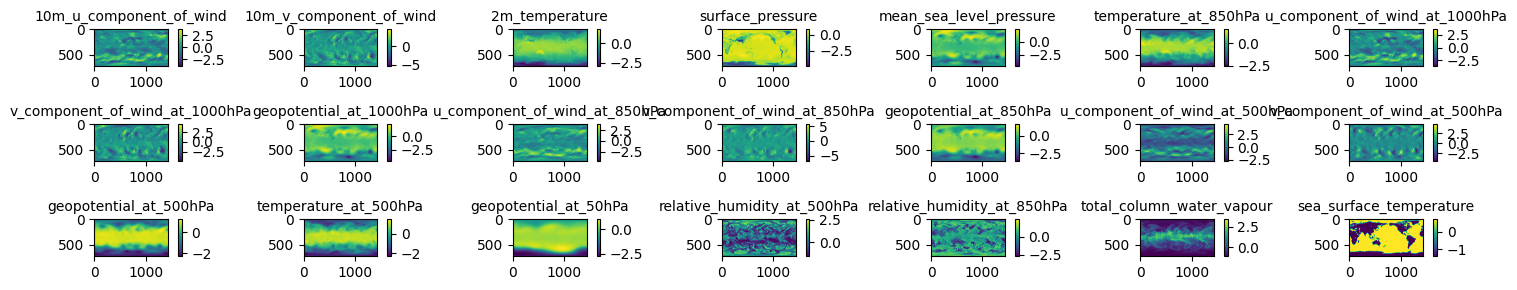

Show outvar (step 0)


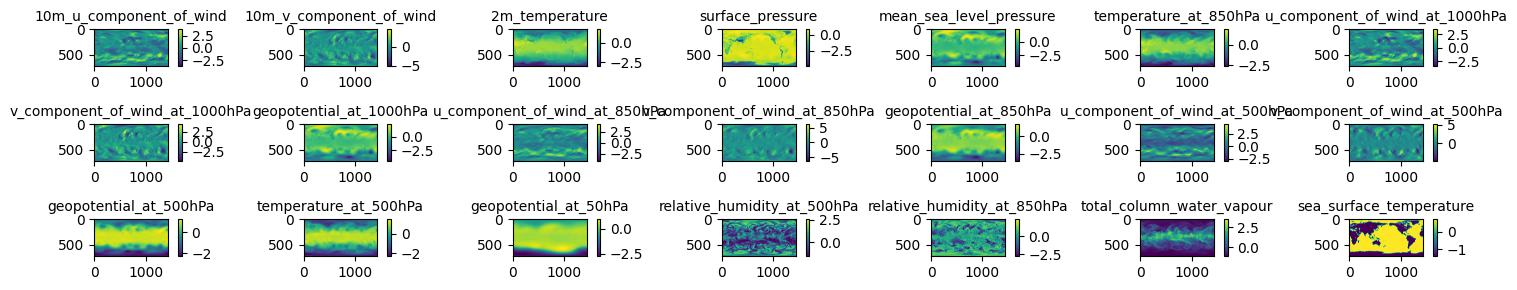

Show outvar (step 1)


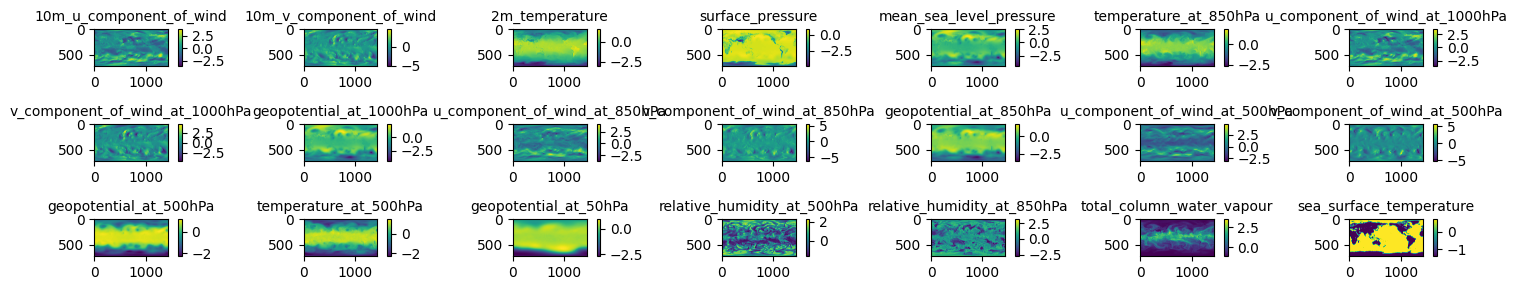

Show outvar (step 2)


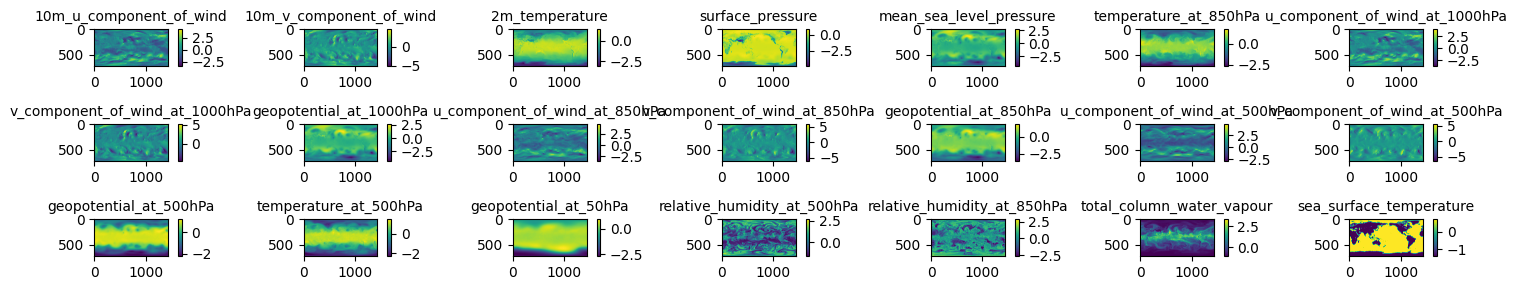

Show outvar (step 3)


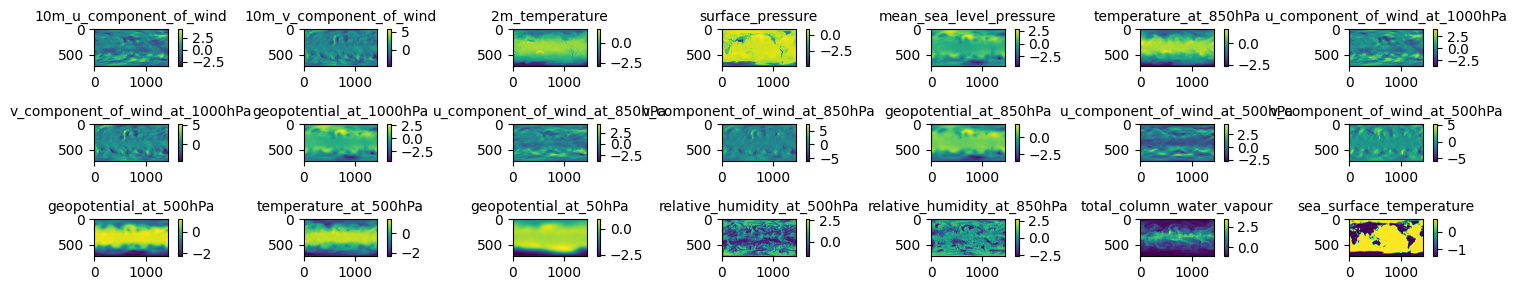

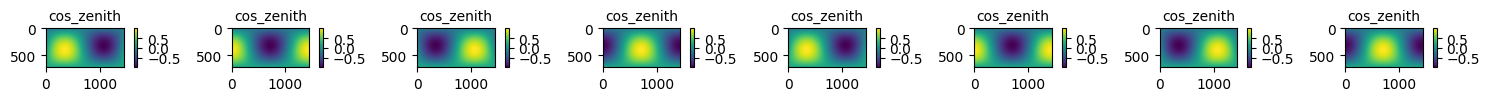

In [40]:
# Some of the default configurations:
# num_iters_step1: 1000       # Number of iterations (backward passes) in the first phase of the learning rate schedule.
# num_iters_step2: 299000     # Number of iterations (backward passes) in the second phase of the learning rate schedule.
# num_iters_step3: 11000      # Number of iterations (backward passes) for incremental fine-tuning, with increments of "step_change_freq".
# step_change_freq: 1000      # Frequency of increments for multi-step fine-tuning.

# Simulating trainig iter
iter = 305000
num_rollout_steps = (iter - (cfg.num_iters_step1 + cfg.num_iters_step2)) // cfg.step_change_freq + 2

print(f"{num_rollout_steps=}")

DataPipe = ERA5HDF5Datapipe
trainer.datapipe = DataPipe(
    data_dir=os.path.join(cfg.dataset_path, "train"),
    stats_dir=os.path.join(cfg.dataset_path, "stats"),
    channels=trainer.channels_list,
    latlon_resolution=cfg.latlon_res,
    interpolation_type=trainer.interpolation_type,
    num_samples_per_year=cfg.num_samples_per_year_train,
    num_steps=num_rollout_steps,
    num_history=cfg.num_history,
    use_cos_zenith=cfg.use_cos_zenith,
    use_time_of_year_index=cfg.use_time_of_year_index,
    cos_zenith_args=trainer.cos_zenith_args,
    batch_size=1,
    num_workers=cfg.num_workers,
    device=dist.device,
    process_rank=dist.rank,
    world_size=dist.world_size,
)

for i, data in enumerate(trainer.datapipe):
    print("=" * 50)
    print("Iteration:", i)
    print("List length:", len(data))
    data = data[0]
    print("-" * 10)

    print("Data keys:", data.keys())
    for key, value in data.items():
        print("\t", key, value.shape)
    print("-" * 10)
    
    invar = data["invar"].to("cpu")
    outvar = data["outvar"].to("cpu")
    cos_zenith = data["cos_zenith"].to("cpu")
    time_of_year_idx = data["time_of_year_idx"]
    print(f"{time_of_year_idx=}")

    print("Show invar")
    fig, axs = plt.subplots(3, 7, figsize=(15, 3))
    for data, ax, label in zip(invar[0], axs.flatten(), metadata["coords"]["channel_labels"]):
        plot(data, label, ax)
    plt.show()

    for step in range(4):
        print(f"Show outvar (step {step})")
        fig, axs = plt.subplots(3, 7, figsize=(15, 3))
        for data, ax, label in zip(outvar[0, step], axs.flatten(), metadata["coords"]["channel_labels"]):
            plot(data, label, ax)
        plt.show()

    # Show cos_zenith
    fig, axs = plt.subplots(1, 8, figsize=(15, 3))
    for data, ax in zip(cos_zenith[0], axs.flatten()):
        plot(data[0], "cos_zenith", ax)

    break

##### Comments
- The input remains from a single time step, while the output is made of 7 time steps.
- `cos_zenith` is generated for all time steps.
- `time_of_year_idx` represents the input time.

## How data is produced by the `datapipe` how is it augmented?

Focusing on the code that matters to answer this question:

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python

from modulus.datapipes.climate import ERA5HDF5Datapipe

def main(cfg: DictConfig) -> None:
    ...
    DataPipe = ERA5HDF5Datapipe
    ...
    trainer = GraphCastTrainer(cfg, dist, rank_zero_logger)
    ...
    while True:
        for _, data in enumerate(trainer.datapipe):
            ...

            # Prepare the input & output
            invar = data[0]["invar"]
            outvar = data[0]["outvar"]
            cos_zenith = data[0]["cos_zenith"]
            time_idx = data[0]["time_of_year_idx"].item()

            invar_cat = prepare_input(
                invar,
                cos_zenith,
                num_history=cfg.num_history,
                static_data=trainer.static_data,
                step=1,
                time_idx=time_idx,
                stride=cfg.stride,
                dt=cfg.dt,
                num_samples_per_year=cfg.num_samples_per_year_train,
                device=dist.device,
            )
            invar_cat = invar_cat.to(dtype=trainer.dtype)
            outvar = outvar.to(dtype=trainer.dtype)

            # training step
            loss = trainer.train(invar_cat, outvar)
            ...
if __name__ == "__main__":
    main()
```
</div>

And the part of the `trainer` object that matters:

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class GraphCastTrainer(BaseTrainer):
    def __init__(self, cfg: DictConfig, dist, rank_zero_logger):
        ...
        if self.static_dataset_path:
            self.static_data = StaticData(self.static_dataset_path, self.latitudes, self.longitudes).get()
            ...
```
</div>


### StaticData

In [55]:
idxs = [0, 1, 3, -3, -2, -1]

trainer.latitudes.shape, trainer.latitudes[idxs], trainer.longitudes.shape, trainer.longitudes[idxs]

(torch.Size([721]),
 tensor([-90.0000, -89.7500, -89.2500,  89.5000,  89.7500,  90.0000]),
 torch.Size([1440]),
 tensor([-179.7500, -179.5000, -179.0000,  179.5000,  179.7500,  180.0000]))

Reviewing the code in https://vscode.dev/github/schuups/DSM500/blob/Baseline/modulus-a5275d8/modulus/utils/graphcast/data_utils.py#L28

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
import netCDF4 as nc
import torch
from torch import Tensor
from torch.nn.functional import interpolate
import numpy as np

from .graph_utils import deg2rad

class StaticData:
    """Class to load static data from netCDF files. Static data includes land-sea mask, geopotential, and latitude-longitude coordinates."""
    def get_lsm(self):
        ds = nc.Dataset(self.lsm_path)["lsm"]
        return ds

    def get_geop(self, normalize: bool = True):
        ds = nc.Dataset(self.geop_path)["z"]
        if normalize:
            ds = (ds - ds.mean()) / ds.std()
        return ds

    def get_lat_lon(self):
        """Computes cosine of latitudes and sine and cosine of longitudes.
        Returns
        -------
        Tensor
            Tensor with shape (1, 3, lat, lon) tha includes cosine of latitudes, sine and cosine of longitudes.
        """
        # cos latitudes
        cos_lat = torch.cos(deg2rad(self.lat))
        # sin longitudes
        sin_lon = torch.sin(deg2rad(self.lon))
        # cos longitudes
        cos_lon = torch.cos(deg2rad(self.lon))
        outvar = torch.cat((cos_lat, sin_lon, cos_lon), dim=1)
        return outvar

    def get(self) -> Tensor:  # pragma: no cover
        """Get all static data.
        Returns
        -------
        Tensor
            Tensor with shape (1, 5, lat, lon) that includes land-sea mask, geopotential, cosine of latitudes, sine and cosine of longitudes.
        """
        lsm = self.get_lsm()
        geop = self.get_geop()
        lat_lon = self.get_lat_lon()
        return torch.concat((lsm, geop, lat_lon), dim=1)
```

</div>

In [60]:
trainer.static_data.shape

torch.Size([1, 5, 721, 1440])

##### Comments
- The class loads land-sea mask, geopotential once.
- Adding cos of latitudes and sin+cos of longitudes adds might be done to help encoding special relationships, or to help handingle the circular nature of the geographic coordinates (i.e. longitudes -180 and 180 represents the same point, yet if taken for their values they would appear distant).
- It adds 5 channels in total.

### prepare_input()

Reviewing the code in https://vscode.dev/github/schuups/DSM500/blob/Baseline/modulus-a5275d8/examples/weather/graphcast/train_utils.py#L21

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
def prepare_input(
    invar,
    cos_zenith=None,
    num_history=0,
    static_data=None,
    step=None,
    time_idx=None,
    stride=1,
    dt=6.0,
    num_samples_per_year=1459
):
    """Prepare input by adding history, cos zenith angle, and static data, if applicable"""

    # Add history
    if num_history > 0:
        # flatten the history dimension
        invar = invar.view(invar.size(0), -1, *(invar.size()[3:]))

    # Add cos zenith
    if cos_zenith is not None:
        cos_zenith = torch.squeeze(cos_zenith, dim=2)
        cos_zenith = torch.clamp(cos_zenith, min=0.0) - 1.0 / np.pi
        invar = torch.concat((invar, cos_zenith[:, step - 1 : num_history + step, ...]), dim=1)

    # Add static data
    if static_data is not None:
        invar = torch.concat((invar, static_data), dim=1)

    # Add clock variables
    if time_idx is not None:
        # Precompute the tensors to concatenate
        sin_day_of_year = torch.zeros(1, num_history + 1, 721, 1440)
        cos_day_of_year = torch.zeros(1, num_history + 1, 721, 1440)
        sin_time_of_day = torch.zeros(1, num_history + 1, 721, 1440)
        cos_time_of_day = torch.zeros(1, num_history + 1, 721, 1440)

        for i in range(num_history + 1):
            # Calculate the adjusted time index
            adjusted_time_idx = (time_idx - i) % num_samples_per_year

            # Compute hour of the year and its decomposition into day of year and time of day
            hour_of_year = adjusted_time_idx * stride * dt
            day_of_year = hour_of_year // 24
            time_of_day = hour_of_year % 24

            # Normalize to the range [0, pi/2]
            normalized_day_of_year = torch.tensor((day_of_year / 365) * (np.pi / 2))
            normalized_time_of_day = torch.tensor((time_of_day / (24 - dt)) * (np.pi / 2))

            # Fill the tensors for the current step
            sin_day_of_year[0, i] = torch.sin(normalized_day_of_year)
            cos_day_of_year[0, i] = torch.cos(normalized_day_of_year)
            sin_time_of_day[0, i] = torch.sin(normalized_time_of_day)
            cos_time_of_day[0, i] = torch.cos(normalized_time_of_day)

        # Concatenate the new channels to invar
        invar = torch.cat(
            (invar, sin_day_of_year, cos_day_of_year, sin_time_of_day, cos_time_of_day),
            dim=1,
        )

    return invar
```

</div>

In [70]:
from train_utils import prepare_input

for _, data in enumerate(trainer.datapipe):
    invar = data[0]["invar"]
    outvar = data[0]["outvar"]
    cos_zenith = data[0]["cos_zenith"]
    time_idx = data[0]["time_of_year_idx"].item()

    invar_cat = prepare_input(
        invar,
        cos_zenith,
        num_history=cfg.num_history,
        static_data=trainer.static_data,
        step=1,
        time_idx=time_idx,
        stride=cfg.stride,
        dt=cfg.dt,
        num_samples_per_year=cfg.num_samples_per_year_train,
        device=dist.device,
    )

    print("cos_zenith", cos_zenith.shape, "time_idx", time_idx)
    print("Input shape, before and after", invar.shape, invar_cat.shape)
    print("Ouput shape, unchanged", outvar.shape)
    break

cos_zenith torch.Size([1, 8, 1, 721, 1440]) time_idx 104
Input shape, before and after torch.Size([1, 21, 721, 1440]) torch.Size([1, 31, 721, 1440])
Ouput shape, unchanged torch.Size([1, 7, 21, 721, 1440])


In [71]:
trainer.datapipe = DataPipe(
    data_dir=os.path.join(cfg.dataset_path, "train"),
    stats_dir=os.path.join(cfg.dataset_path, "stats"),
    channels=trainer.channels_list,
    latlon_resolution=cfg.latlon_res,
    interpolation_type=trainer.interpolation_type,
    num_samples_per_year=cfg.num_samples_per_year_train,
    num_steps=5, # num_rollout_steps,
    num_history=3, # Setting history to 3 instead 0,
    use_cos_zenith=cfg.use_cos_zenith,
    use_time_of_year_index=cfg.use_time_of_year_index,
    cos_zenith_args=trainer.cos_zenith_args,
    batch_size=1,
    num_workers=cfg.num_workers,
    device=dist.device,
    process_rank=dist.rank,
    world_size=dist.world_size,
)

for _, data in enumerate(trainer.datapipe):
    invar = data[0]["invar"]
    outvar = data[0]["outvar"]
    cos_zenith = data[0]["cos_zenith"]
    time_idx = data[0]["time_of_year_idx"].item()

    invar_cat = prepare_input(
        invar,
        cos_zenith,
        num_history=3, # cfg.num_history,
        static_data=trainer.static_data,
        step=5,
        time_idx=time_idx,
        stride=cfg.stride,
        dt=cfg.dt,
        num_samples_per_year=cfg.num_samples_per_year_train,
        device=dist.device,
    )

    print("cos_zenith", cos_zenith.shape, "time_idx", time_idx)
    print("Input shape, before and after", invar.shape, invar_cat.shape)
    print("Ouput shape, unchanged", outvar.shape)
    break

cos_zenith torch.Size([1, 9, 1, 721, 1440]) time_idx 1165
Input shape, before and after torch.Size([1, 4, 21, 721, 1440]) torch.Size([1, 109, 721, 1440])
Ouput shape, unchanged torch.Size([1, 5, 21, 721, 1440])


##### Comment

Assuming no history:
- Appends the static data to the input, thus adding 5 channels.
- It contatenates the cos_zenith to the input, thus adding 1 channel
- It adds information about the time of day and time of year, thus adding 4 channels
- Not very clear what it does if there is an history

When history is added:
- The input shape changes and one dimension is added (if history = 0, the history dimension does not exist!)
- History is squashed into the single bulk input. 5 channels (the static ones) remain, and then for each history element, the usual cos_zenith and 4 time references are added. 

## How data is produced within the `datapipe` class (i.e. what happens in the iterator)?

The class `ERA5HDF5Datapipe` is defined at https://vscode.dev/github/schuups/DSM500/blob/Baseline/modulus-a5275d8/modulus/datapipes/climate/era5_hdf5.py#L57 To make it more easily readable here is a simplified version, with the superflous removed.

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class ERA5HDF5Datapipe(Datapipe):
    """ERA5 DALI data pipeline for HDF5 files"""
    def __init__(...):
        ...
        # cos zenith defaults
        if use_cos_zenith:
            cos_zenith_args["dt"] = cos_zenith_args.get("dt", 6.0)
            cos_zenith_args["start_year"] = cos_zenith_args.get("start_year", 1980)
            cos_zenith_args["latlon_bounds"] = cos_zenith_args.get("latlon_bounds", ((90, -90), (0, 360),),)
        self.latlon_bounds = cos_zenith_args.get("latlon_bounds")

        self.output_keys = ["invar", "outvar"]

        # Get latlon for zenith angle
        if self.use_cos_zenith:
            self.data_latlon = np.stack(latlon_grid(bounds=self.latlon_bounds, shape=self.latlon_resolution), axis=0,)
            self.latlon_dali = dali.types.Constant(self.data_latlon)
            self.output_keys += ["cos_zenith"]

        if self.use_time_of_year_index:
            self.output_keys += ["time_of_year_idx"]

        self.parse_dataset_files()
        self.load_statistics()

        self.pipe = self._create_pipeline()

    def parse_dataset_files(self) -> None:
        """Parses the data directory for valid HDF5 files and determines training samples"""
        # get all input data files
        self.data_paths = sorted(self.data_dir.glob("????.h5"))
        self.n_years = len(self.data_paths)
        
        # get total number of examples and image shape from the first file, assuming other files have exactly the same format.
        with h5py.File(self.data_paths[0], "r") as f:
            ...
            self.img_shape = f["fields"].shape[2:]
            ...
            # Get total length
            self.total_length = self.n_years * self.num_samples_per_year
            self.length = self.total_length

    def load_statistics(self) -> None:
        """Loads ERA5 statistics from pre-computed numpy files
           The statistic files should be of name global_means.npy and global_std.npy with a shape of [1, C, 1, 1] located in the stat_dir.
        """
        # load normalisation values
        mean_stat_file = self.stats_dir / Path("global_means.npy")
        std_stat_file = self.stats_dir / Path("global_stds.npy")

        # they have shape [1, C, 1, 1]
        self.mu = np.load(str(mean_stat_file))[:, self.channels]
        self.sd = np.load(str(std_stat_file))[:, self.channels]

        if not self.mu.shape == self.sd.shape == (1, len(self.channels), 1, 1):
            raise AssertionError("Error, normalisation arrays have wrong shape")

    def _create_pipeline(self) -> dali.Pipeline:
        """Create DALI pipeline"""
        pipe = dali.Pipeline(
            batch_size=self.batch_size,
            num_threads=2,
            prefetch_queue_depth=2,
            py_num_workers=self.num_workers,
            device_id=self.device.index,
            py_start_method="spawn",
        )

        with pipe:
            source = ERA5DaliExternalSource(
                data_paths=self.data_paths,
                num_samples=self.total_length,
            )

            # Update length of dataset
            self.length = len(source) // self.batch_size

            # Read current batch.
            invar, outvar, timestamps, time_of_year_idx = dali.fn.external_source(
                source,
                num_outputs=4,
                parallel=True,
                batch=False,
                layout=self.layout,
            )

            # Standardize.
            if self.stats_dir is not None:
                invar = dali.fn.normalize(invar, mean=self.mu[0], stddev=self.sd[0])
                outvar = dali.fn.normalize(outvar, mean=self.mu, stddev=self.sd)

            # cos zenith angle
            if self.use_cos_zenith:
                cos_zenith = dali.fn.cast(cos_zenith_angle(timestamps, latlon=self.latlon_dali), dtype=dali.types.FLOAT,)

            # Set outputs.
            outputs = (invar, outvar)
            if self.use_cos_zenith:
                outputs += (cos_zenith,)
            if self.use_time_of_year_index:
                outputs += (time_of_year_idx,)
            pipe.set_outputs(*outputs)

        return pipe

    def __iter__(self):
        # Reset the pipeline before creating an iterator to enable epochs.
        self.pipe.reset()
        # Create DALI PyTorch iterator.
        return dali_pth.DALIGenericIterator([self.pipe], self.output_keys)

    def __len__(self):
        return self.length

```
</div>

It relies on the `ERA5DaliExternalSource` class. Here again a simplified version of the code, to help understanding.

<div style="font-size: 10px; border: 1px solid black; padding: 10px; margin-top: 15px; margin-bottom: 15px; border-radius: 5px; max-width: 900px;">

```python
class ERA5DaliExternalSource:
    def __init__(
        data_paths: Iterable[str],
        num_samples: int,
        batch_size = 1
    ):
        self.data_paths = list(data_paths)
        ...
        self.last_epoch = None
        self.indices = np.arange(num_samples)

        # Shard from indices if running in parallel
        self.indices = np.array_split(self.indices, world_size)[process_rank]

        # Get number of full batches, ignore possible last incomplete batch for now.
        # Also, DALI external source does not support incomplete batches in parallel mode.
        self.num_batches = len(self.indices) // self.batch_size

        # cos zenith args
        if self.use_cos_zenith:
            self.dt: float = cos_zenith_args.get("dt")
            self.start_year: int = cos_zenith_args.get("start_year")

    def __call__(self, sample_info: dali.types.SampleInfo) -> Tuple[Tensor, Tensor, np.ndarray]:
        if self.data_files is None:
            # This will be called once per worker. Workers are persistent,
            # so there is no need to explicitly close the files - this will be done
            # when corresponding pipeline/dataset is destroyed.
            self.data_files = [h5py.File(path, "r") for path in self.data_paths]

        # Shuffle before the next epoch starts.
        if self.shuffle and sample_info.epoch_idx != self.last_epoch:
            # All workers use the same rng seed so the resulting indices are the same across workers.
            np.random.default_rng(seed=sample_info.epoch_idx).shuffle(self.indices)
            self.last_epoch = sample_info.epoch_idx

        # Get local indices from global index.
        idx = self.indices[sample_info.idx_in_epoch]
        year_idx = idx // self.num_samples_per_year
        in_idx = idx % self.num_samples_per_year

        # Load sequence of timestamps
        if self.use_cos_zenith:
            year = self.start_year + year_idx
            start_time = datetime(year, 1, 1, tzinfo=pytz.utc) + timedelta(hours=int(in_idx) * self.dt)
            timestamps = np.array([
                (start_time + timedelta(hours=i * self.stride * self.dt)).timestamp() for i in range(self.num_steps + 1)
            ])
        else:
            timestamps = np.array([])
        if self.use_time_of_year_index:
            time_of_year_idx = in_idx
        else:
            time_of_year_idx = -1

        data = self.data_files[year_idx]["fields"]
        
        invar = data[in_idx, self.chans]
        outvar = np.empty((self.num_steps,) + invar.shape[-3:], dtype=invar.dtype)

        for i in range(self.num_steps):
            out_idx = in_idx + (i + 1) * self.stride
            outvar[i] = data[out_idx, self.chans]

        return invar, outvar, timestamps, np.array([time_of_year_idx])

    def __len__(self):
        return len(self.indices)
```

</div>

In [42]:
from pathlib import Path
from modulus.datapipes.climate.era5_hdf5 import ERA5DaliExternalSource
import nvidia.dali as dali
import nvidia.dali.plugin.pytorch as dali_pth

# Reproduce data as per training script
data_dir = to_absolute_path(os.path.join(cfg.dataset_path, "train"))
data_dir = Path(data_dir)
data_paths = sorted(data_dir.glob("????.h5"))
n_years = len(data_paths)
num_samples_per_year = cfg.num_samples_per_year_train
total_length = n_years * num_samples_per_year
channels = [i for i in range(cfg.num_channels_climate)]
cos_zenith_args = {
    "dt": cfg.dt,
    "start_year": cfg.start_year,
}

source = ERA5DaliExternalSource(
    data_paths=data_paths,
    num_samples=total_length,
    channels=channels,
    stride=1,
    num_steps=1,
    num_history=0,
    num_samples_per_year=num_samples_per_year,
    use_cos_zenith=True,
    cos_zenith_args=cos_zenith_args,
    use_time_of_year_index=True,
    batch_size=1,
    shuffle=True,
    process_rank=0,
    world_size=1,
)

In [55]:
temp_pipe = DataPipe(
    data_dir=os.path.join(cfg.dataset_path, "train"),
    stats_dir=os.path.join(cfg.dataset_path, "stats"),
    channels=trainer.channels_list,
    latlon_resolution=cfg.latlon_res,
    interpolation_type=trainer.interpolation_type,
    num_samples_per_year=cfg.num_samples_per_year_train,
    num_steps=1,
    num_history=0,
    use_cos_zenith=cfg.use_cos_zenith,
    use_time_of_year_index=cfg.use_time_of_year_index,
    cos_zenith_args=trainer.cos_zenith_args,
    batch_size=1,
    num_workers=cfg.num_workers,
    device=dist.device,
    process_rank=dist.rank,
    world_size=dist.world_size,
)

output_keys = ["invar", "outvar", "cos_zenith", "time_of_year_idx"]

In [57]:
temp_pipe.pipe.reset()
iterator = dali_pth.DALIGenericIterator([temp_pipe.pipe], output_keys)

In [60]:
next(iterator)[0]['invar'].shape

torch.Size([1, 21, 721, 1440])